In [3]:
print('###############################################   LAB 4   ##############################################')
print('################### Script written by Dr Alex Ter-Sarkisov@City, University of London, 2022 ############')
print('#####################   DEEP LEARNING FOR IMAGE ANALYSIS, MSC IN ARTIFICIAL INTELLIGENCE    ############')
print('########################################################################################################')
import numpy as np
import os,sys,re
from pathlib import Path as Path
from PIL import Image as PILImage
import torch
import torchvision
from torchvision import transforms as transforms
import dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torch.utils import data
import matplotlib.pyplot as plt
import util
import torch.utils as utils
import matplotlib.patches as patches
from collections import OrderedDict
from matplotlib.patches import Rectangle
print(torchvision.__file__)

###############################################   LAB 4   ##############################################
################### Script written by Dr Alex Ter-Sarkisov@City, University of London, 2022 ############
#####################   DEEP LEARNING FOR IMAGE ANALYSIS, MSC IN ARTIFICIAL INTELLIGENCE    ############
########################################################################################################
/opt/conda/lib/python3.8/site-packages/torchvision/__init__.py


In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
   device = torch.device('cuda')
   
pascal_object_categories = ['__bgr__', 'aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                      'cow', 'diningtable', 'dog', 'horse',
                      'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

pascal_voc_classes = dict(zip(pascal_object_categories,
                              range(len(pascal_object_categories))))
pascal_voc_classes_name = dict(zip(range(len(pascal_object_categories)),
                               pascal_object_categories))

print('Pascal VOC classes')  
print("A total of {0:} classes\n".format(len(pascal_voc_classes)-1))
for k, n in pascal_voc_classes.items():    
    print(n,k)

Pascal VOC classes
A total of 20 classes

0 __bgr__
1 aeroplane
2 bicycle
3 bird
4 boat
5 bottle
6 bus
7 car
8 cat
9 chair
10 cow
11 diningtable
12 dog
13 horse
14 motorbike
15 person
16 pottedplant
17 sheep
18 sofa
19 train
20 tvmonitor


#### Annotations file doesn't match training data

In [3]:
print(len(sorted(Path('annotations').glob('*'))))
print(len(sorted(Path('/mnt/data/course/psarin/inm705/pascal_voc_2012/train_data').glob('*'))))
print(len(sorted(Path('/mnt/data/course/psarin/inm705/pascal_voc_2012/test_data').glob('*'))))
print(len(sorted(Path('/mnt/data/course/psarin/inm705/pascal_voc_2012/val_data').glob('*'))))

976
2000
413
500


In [4]:
sorted(Path('/mnt/data/course/psarin/inm705/pascal_voc_2012/train_data').glob('*'))[:2]

[PosixPath('/mnt/data/course/psarin/inm705/pascal_voc_2012/train_data/2007_000032.jpg'),
 PosixPath('/mnt/data/course/psarin/inm705/pascal_voc_2012/train_data/2007_000042.jpg')]

In [5]:
sorted(Path('annotations').glob('*'))[:3]

[PosixPath('annotations/.ipynb_checkpoints'),
 PosixPath('annotations/2007_000032.xml'),
 PosixPath('annotations/2007_000033.xml')]

In [6]:
train_imgs = []
test_imgs = []
val_imgs = []
train_files = sorted(Path('/mnt/data/course/psarin/inm705/pascal_voc_2012/train_data').glob('*'))
test_files = sorted(Path('/mnt/data/course/psarin/inm705/pascal_voc_2012/test_data').glob('*'))
val_files = sorted(Path('/mnt/data/course/psarin/inm705/pascal_voc_2012/val_data').glob('*'))
gt_files = [f.stem for f in sorted(Path('annotations').glob('*'))[1:]] #first file is a checkpoint file
for f in train_files:
    if f.stem in gt_files:
        train_imgs.append(f)
for f in test_files:
    if f.stem in gt_files:
        test_imgs.append(f)
for f in val_files:
    if f.stem in gt_files:
        val_imgs.append(f)

for l in [train_imgs, test_imgs, val_imgs, gt_files]:
    print(len(l))
print(len(train_imgs)+len(test_imgs)+len(val_imgs))

670
137
168
975
975


In [7]:
img_max_size = [800,800]

# This loads Faster R-CNN model from torchvision repository
# num_classes is 91 - cos model trained on COCO dataset. It will work on pascal VOC cos
# pascal classes are a subset of COCO classes
frcnn_args = {'box_score_thresh':0.5, 'num_classes':91, 'rpn_batch_size_per_image':256, 'box_batch_size_per_image':256}
#################################### EVAL OF THE PRETRAINED MODEL ##############################
frcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False, **frcnn_args)
# print(frcnn_model)

In [8]:
frcnn_model.load_state_dict(torch.load("fasterrcnn_resnet50_fpn_coco-258fb6c6.pth",
                                       map_location="cpu"))

<All keys matched successfully>

/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


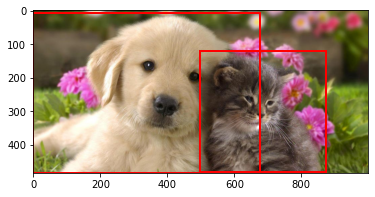

In [9]:
device = torch.device('cpu')
frcnn_model.to(device).eval()
frcnn_model.eval();
# deploy the pretrained model on an image
# Exercise (suggested):
# add predicted class, make the boundary thicker 
# depending on the confidence, etc 
def inference_faster_rcnn(im, idx=None, gt=False):
    im = PILImage.open(im)
    img = np.array(im)
    img = transforms.ToTensor()(img)    
    out = frcnn_model([img])    
    scores = out[0]['scores']
    bboxes = out[0]['boxes']
    classes = out[0]['labels']
    if gt:
        _, _, y = data_point.__getitem__(idx)
        bboxes_gt = y['boxes']
    if len(scores)>0 or gt:
        plt.imshow(im)
        ax=plt.gca()
        for b in bboxes:
            b=b.detach().numpy()
            rect = Rectangle((b[0],b[1]), b[2]-b[0], b[3]-b[1],
                             linewidth=2, edgecolor='red',
                             facecolor='none')
            ax.add_patch(rect)
        if gt:
            for b in bboxes_gt:
                b=b.detach().numpy()
                rect = Rectangle((b[0],b[1]), b[2]-b[0], b[3]-b[1],
                                 linewidth=2, edgecolor='green',
                                 facecolor='none')
                ax.add_patch(rect)
            plt.show()
        
    return out
    
out = inference_faster_rcnn("dogcat1.jpg")


In [10]:
out
# the labels refer to COCO labels so 18 is dog and 17 is cat

[{'boxes': tensor([[  0.0000,   6.8645, 675.1798, 485.0000],
          [498.8008, 120.2702, 873.7836, 481.8799]], grad_fn=<StackBackward0>),
  'labels': tensor([18, 17]),
  'scores': tensor([0.9719, 0.9259], grad_fn=<IndexBackward0>)}]

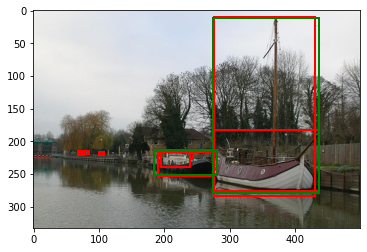

[{'boxes': tensor([[191.0756, 215.7789, 276.6644, 252.6182],
        [274.8417, 182.3042, 436.9721, 276.0569],
        [276.4491,   9.9223, 430.5964, 283.4052],
        [ 99.7082, 216.2215, 107.7450, 220.8777],
        [238.8122, 215.3296, 244.1159, 227.4291],
        [ 68.6437, 215.1332,  77.4794, 221.1143],
        [ 77.4507, 214.4896,  84.4226, 219.6557],
        [ 69.8668, 217.6421,  77.0561, 221.6745],
        [194.8015, 213.9442, 238.9980, 238.9783]], grad_fn=<StackBackward0>), 'labels': tensor([9, 9, 9, 3, 1, 3, 3, 3, 9]), 'scores': tensor([0.9762, 0.9531, 0.9080, 0.8991, 0.8660, 0.8030, 0.8024, 0.6044, 0.5993],
       grad_fn=<IndexBackward0>)}]


In [12]:
device = torch.device('cpu')
frcnn_model.to(device).eval()

i = 2
idx, X, y = data_point.__getitem__(i)
type(X)

out = inference_faster_rcnn(data_point.imgs[i], idx=i, gt=True)
print(out)

In [11]:
# frcnn_model.load_state_dict(torch.load("pascal_voc_detection_model.pth",
#                                        # map_location="cpu"
#                                       )
#                            )

data_args= {'classes':pascal_voc_classes,
            # 'dir':'/mnt/data/course/psarin/inm705/pascal_voc_2012/train_data',
            'dir_label':'./annotations',
           'img_list':train_imgs}
data_point = dataset.PascalVOC2012DatasetObjectDetection(**data_args)
dataloader_args = {'batch_size':1, 'shuffle':True}
dataloader = data.DataLoader(data_point, **dataloader_args)
total_epoch = 10

frcnn_model.train()

if device == torch.device('cuda'):
    frcnn_model = frcnn_model.to(device)

optimizer_pars = {'lr':1e-5, 'weight_decay':1e-3}
optimizer = torch.optim.Adam(list(frcnn_model.parameters()),**optimizer_pars)

In [ ]:
for e in range(total_epoch):
    epoch_loss = 0
    for id, batch in enumerate(dataloader):
        optimizer.zero_grad()
        idx,X,y = batch
        if device == torch.device('cuda'):
            X,y['labels'],y['boxes'] = X.to(device), y['labels'].to(device), y['boxes'].to(device)
        # list of images        
        images = [im for im in X]                
        targets = []
        lab={}
        # THIS IS IMPORTANT!!!!!        
        # get rid of the first dimension (batch)        
        # REPEAT: DO NOT USE BATCH DIMENSION           
        # 
        lab['boxes'] = y['boxes'].squeeze_(0)
        lab['labels']= y['labels'].squeeze_(0)
        targets.append(lab)
        # avoid empty objects
        if len(targets)>0:
            loss = frcnn_model(images, targets)            
            total_loss = 0
            for k in loss.keys():
                total_loss += loss[k]
            total_loss.backward()
            optimizer.step()
            epoch_loss +=total_loss.item()
    epoch_loss/=len(dataloader)
    print("Loss={0:.4f} in Epoch={1:d}".format(epoch_loss, e))
        

In [ ]:
torch.save(frcnn_model.state_dict(), "pascal_voc_detection_model.pth")
device = torch.device('cpu')
frcnn_model.to(device).eval()
inference_faster_rcnn("dogcat1.jpg")
################################################ EXERCISE ######################################################
# IoU thresholds. By default the model computes AP for each threshold between 0.5 and 0.95 with the step of 0.05
#thresholds = torch.arange(0.5, 1, 0.05).to(device)
#mean_aps_all_th = torch.zeros(thresholds.size()[0]).to(device)
#ap_th = OrderedDict()

# inputs (dimensions): ground truth boxes (N1x4), ground truth classes (N1), predicted boxes (N2,4), predicted classes (N2)
# confidence scores (N2), IoU threshold (float), device (string)
#def compute_precision():    
    # add the functionality to compute average precision 
    # for the given IoU threshold value.
    # You need to use the compute_ap method from utils.py 
    # to compute overlaps among predicted and gt boxes and
    # inference_faster_rcnn method to output predicted boxes and labels.
    # You need to pass gt_boxes, gt_class_ids, pred_boxes, pred_class_ids, pred_scores, iou_threshold and device
    # arguments to compute_ap method
    # The threshold for confidence score is a hyperparameter in Faster R-CNN: box_score_thresh that you can change
    # All predictions with confidence scores less than this threshold are discarded.
    
# this is the loop on all thresholds 
#for t, th in enumerate(thresholds):
#    # main method
#    ap = compute_precision(frcnn_model, th, device)
#    mean_aps_all_th[t] = ap
##    th_name = 'AP@{0:.2f}'.format(th)
    #ap_th[th_name] = ap

In [ ]:
#print("mAP:{0:.2f}".format(mean_aps_all_th.mean().item()))
#for the, p in ap_th.items():
#    print("{0:}:{1:.4f}".format(the, p))